In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from torch import nn
from torch.nn import Sigmoid as sig

# Часть 1 (и 2)

Посмотрим на данные

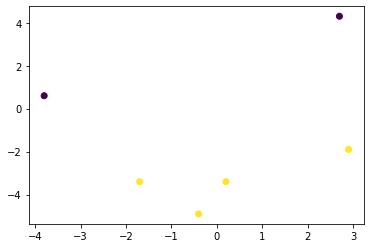

In [ ]:
X = np.array([[2.7, -3.8, -0.4, -1.7, 2.9, 0.2],
        [4.3, 0.6, -4.9, -3.4, -1.9, -3.4]])
y = np.array([0, 0, 1, 1, 1, 1])

fig, ax = plt.subplots()
ax.scatter(X[0], X[1], c=y)
fig.show()

### Случайный датасет 

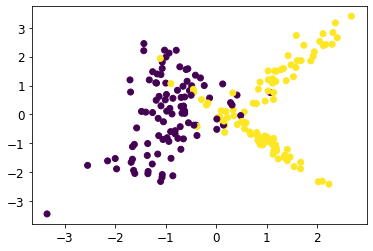

In [ ]:
from sklearn.datasets import make_blobs, make_classification
# X, y = make_blobs(100, centers=2)
X, y = make_classification(200, 2, n_informative=2, n_redundant=0, n_repeated=0)
X = X.T
fig, ax = plt.subplots()
ax.scatter(X[0], X[1], c=y)
fig.show()

### Создание и обучение модели

#### Теория
У нас задача бинарной классификации. Решать мы ее будем посредством разделяющей прямой. В качестве модели нам будет достаточно одного нейрона, так как нейрон состоит из 2 частей: сумматора и функции активации. Сумматор будет отвечать за разделяющую прямую, а функция активации за связь между прямой и классом объектов.
Сумматор:

$$ f = w_1 x_1 + w_2 x_2 + b, где $$

$b$ (bias) – свободный коэффециент, отвечающий за смещение разделяющей прямой от нуля,
$w_1, w_2$ – весовые коэффециенты, отвечающие на заправление прямой,
$(x_1, x_2) \in X, X$ – множество семплов.

Функция активации в нашем случае – сигмоида:
$$ \sigma(f(x)) = \frac{1}{1 + e^{-f(x)}}  = \frac{1}{1 + e^{- (w_1 x_1 + w_2 x_2 + b)}}$$

Так как у нас классификация бинарная, в качестве лосс-функции нам лучше всего подойдет логлосс: 

$$ L = - \frac{1}{n}\sum\limits_{i=1}^n (y_iln\sigma_i + (1 - y_i)ln(1-\sigma_i)) \rightarrow min, где $$
$\sigma_i \equiv \sigma (f(X_i)), где X_i \in X,
y_i – класс X_i $

Но по заданию так же нужно использовать MAE: 
$$MAE = \frac{1}{n}\sum\limits_{i=1}^n |y_i - \sigma_i|$$

Линию раздела зададим формулой (из f = 0 следует, что): 
$$ x_2 = - \frac{w_1}{w_2} x_1 - \frac{b}{w_2}$$  



In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super(Model, self).__init__()
        self.lin = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.lin(x)

In [ ]:
GPU = torch.device('cuda:0')
CPU = torch.device('cpu')
model = Model(2, 1).cuda()

sigmoid = nn.Sigmoid()
X_train = torch.FloatTensor(X.T).cuda()
y_train = torch.FloatTensor(y.reshape(-1, 1)).cuda()
history = pd.DataFrame(columns=['BSELoss', 'model_bias',
                                'model_w_1', 'model_w_2', 'L1Loss'])
true_lables_history = np.array([True] * len(y.reshape(-1)))
# opt = torch.optim.Rprop(model.parameters(), lr=0.01)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

bse = torch.nn.BCEWithLogitsLoss()
mae = torch.nn.L1Loss()

def get_history_moment_data(bse, mae, model):
    dict_to_add = {
        'BSELoss': float(bse.clone().to(CPU)),
        'model_bias': float(model.lin.bias.clone().to(CPU)),
        'model_w_1': float(model.lin.weight[0, 0].clone().to(CPU)),
        'model_w_2': float(model.lin.weight[0, 1].clone().to(CPU)),
        'L1Loss': float(mae.clone().to(CPU)),
    }
    return dict_to_add

def fit(model, X, y, opt, history, true_lables_history, epochs = 100):
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            model.train()
            opt.zero_grad()
            output = model.forward(X_train)
            bse_value = bse(output, y_train)
            mae_value = mae(sigmoid(output), y_train)
            bse_value.backward()
            opt.step()
            g = get_history_moment_data(bse_value, mae_value, model)
            history = history.append(g, ignore_index=True)
            answ = ((sigmoid(model(X_train).to(CPU).data) + 0.5).int() == y_train.to(CPU)).numpy()
            true_lables_history = np.vstack((true_lables_history, answ.T))
            pbar.update()
    if np.mean(true_lables_history[0]) == 1 :
        true_lables_history = true_lables_history[1:]
    return model, history, true_lables_history

In [ ]:
model, history, true_lables_history = fit(model, X, y, opt, history, true_lables_history, epochs = 200)

100%|██████████| 200/200 [00:00<00:00, 221.28it/s]


### Анимация

In [ ]:
import matplotlib
import imageio
import time
plt.rcParams.update({'font.size': 12})

def dividing_line_y(W, b, x):
    return - W[0] / W[1] * x - b / W[1]

def plot_for_offset(i, history=history):
    fig, axes = plt.subplots(3,2, figsize=(15, 15))
    ax = axes[0][0]
    ax2 = axes[1][0]
    ax3 = axes[2][0]
    ax4 = axes[0][1]
    ax5 = axes[1][1]
    ax6 = axes[2][1]
    loss, b, w0, w1, l1loss = history.iloc[i, :].values
    losses = history.values.T[0]

    trace = 5 if i >= 5 else i
    for k in range(trace):
        loss, b, w0, w1, l1loss = history.iloc[i - trace + k, :].values
        line_x = np.linspace(min(X[0]), max(X[0]), num=2)
        line_y = dividing_line_y((w0, w1), b, line_x)
        ax.plot(line_x, line_y, '--', color='grey', alpha=0.2 * k)
    
    line_x = np.linspace(min(X[0]), max(X[0]), num=2)
    line_y = dividing_line_y((w0, w1), b, line_x)
    ax.plot(line_x, line_y, color='black')
    true_X = X.T[np.array(np.where(true_lables_history[i]))][0].T
    false_X = X.T[np.array(np.where(~true_lables_history[i]))][0].T
    # 
    ax.scatter(true_X[0], true_X[1], color='green', s=100)
    ax.scatter(true_X[0], true_X[1], color='white', s=55)
    ax.scatter(false_X[0], false_X[1], color='red', s=100)
    ax.scatter(false_X[0], false_X[1], color='white', s=55)
    ax.scatter(X[0], X[1], c=y, s=25)
    
    # информация о кол-ве правильно предсказанных точках
    bounds = [[min(X[0]), max(X[0])],
              [min(X[1]), max(X[1])]]
    ax.scatter(bounds[0][1]-1, bounds[1][1], color='green', s=100)
    ax.scatter(bounds[0][1]-1, bounds[1][1], color='white', s=55)
    # ax.annotate('{:.1f} % ({} / {}) '.format(100 * len(true_X.T) / len(X.T), len(true_X.T), len(X.T)),
    # (bounds[0][1]+0.2-1, bounds[1][1]-0.2))
    ax.annotate('{:.1f} %'.format(100 * len(true_X.T) / len(X.T)),
                (bounds[0][1]+0.2-1, bounds[1][1]-0.2))


    ax.scatter(bounds[0][1]-1, bounds[1][1]-1, color='red', s=100)
    ax.scatter(bounds[0][1]-1, bounds[1][1]-1, color='white', s=55)
    ax.annotate('{:.1f} % ({} / {}) '.format(100 * len(false_X.T) / len(X.T), len(false_X.T), len(X.T)),
    (bounds[0][1]+0.2-1, bounds[1][1]-1.2))

    # настройка осей
    field_x = (bounds[0][1] - bounds[0][0])/bounds[0][1]/3
    field_y = (bounds[1][1] - bounds[1][0])/bounds[1][1]/3
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    bias_plus = '- ' if  - b / w1 < 0 else '+ '
    ax.annotate('y = {:.3f}x  {}{:.3f}'.format(- w0 / w1, bias_plus, abs(- b / w1)),
                (bounds[0][0], bounds[1][1]), )
    
    ax.set_xbound(min(X[0]) - field_x, max(X[0]) + field_x)
    ax.set_ybound(min(X[1]) - field_y, max(X[1]) + field_y)

    ax2.plot(losses[:i+1])
    ax2.set_ybound(min(losses) - 0.1, max(losses)+0.1)
    ax2.set_xbound(0, len(history))
    ax2.set_ylabel('BSELoss')
    ax2.set_xlabel('epochs')

    maelosses = history.values.T[4]
    ax3.plot(maelosses[:i+1])
    ax3.set_ybound(min(maelosses) - 0.1, max(maelosses)+0.1)
    ax3.set_xbound(0, len(history))
    ax3.set_ylabel('MAE')
    ax3.set_xlabel('epochs')

    biases = history.values.T[1]
    ax4.plot(biases[:i+1])
    ax4.set_ybound(min(biases) - 0.1, max(biases)+0.1)
    ax4.set_xbound(0, len(history))
    ax4.set_ylabel('bias')
    ax4.set_xlabel('epochs')

    w1s = history.values.T[2]
    ax5.plot(w1s[:i+1])
    ax5.set_ybound(min(w1s) - 0.1, max(w1s)+0.1)
    ax5.set_xbound(0, len(history))
    ax5.set_ylabel('weight 1')
    ax5.set_xlabel('epochs')

    w2s = history.values.T[3]
    ax6.plot(w2s[:i+1])
    ax6.set_ybound(min(w2s) - 0.1, max(w2s)+0.1)
    ax6.set_xbound(0, len(history))
    ax6.set_ylabel('weight 2')
    ax6.set_xlabel('epochs')

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if i == len(history) - 1:
        fig.savefig('results.png')
    return image

def get_animation(history):
    print('Creating animation...')
    time.sleep(0.5)
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imges = []
    with tqdm(total=len(history)) as pbar:
        for i in range(len(history)):
            imges.append(plot_for_offset(i, history=history))
            pbar.update(1)
    print('Saving... ', end='')
    imageio.mimsave('./anim.gif', imges, fps=20)
    print('done')

### Вывод результатов

In [ ]:
get_animation(history)

Creating animation...


100%|██████████| 300/300 [02:17<00:00,  2.18it/s]


Saving... done


# Часть 3


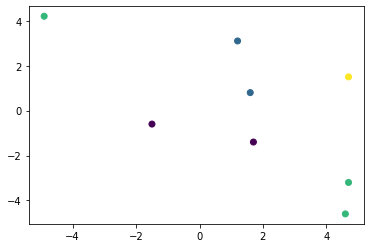

In [3]:
X = np.array([[-1.5, 4.6, 4.7, 1.6, 1.7, 1.2, -4.9, 4.7],
        [-0.6, -4.6, -3.2, 0.8, -1.4, 3.1, 4.2, 1.5]])
y_for_drowing = np.array([0, 2, 2, 1, 0, 1, 2, 3])
y = np.array([[0, 0, 0, 1, 0, 1, 0, 1],
             [0, 1, 1, 0, 0, 0, 1, 1]])
y = y_for_drowing

fig, ax = plt.subplots()
ax.scatter(X[0], X[1], c=y_for_drowing)
fig.show()

In [4]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super(Model, self).__init__()
        self.lin = nn.Linear(in_features, 2)
        self.sig = nn.Sigmoid()
        self.lin2 = nn.Linear(2, out_features)

    def forward(self, x):
        x = self.lin(x)
        x = self.sig(x)
        x = self.lin2(x)
        return x

In [5]:
GPU = torch.device('cuda:0')
CPU = torch.device('cpu')
model = Model(2, 4).cuda()

sigmoid = nn.Sigmoid()
X_train = torch.FloatTensor(X.T).cuda()
y_train = torch.LongTensor(y.reshape(-1, 1)).cuda()
history = pd.DataFrame(columns=['CrossEntropyLoss', 'model_bias',
                                'model_w_11', 'model_w_12',
                                'model_w_21', 'model_w_22'])
true_lables_history = np.array([True] * len(y.reshape(-1)))
opt = torch.optim.Rprop(model.parameters(), lr=0.01)

cel = torch.nn.CrossEntropyLoss()

def get_history_moment_data(cel, model):
    dict_to_add = {
        'CrossEntropyLoss': float(cel.clone().to(CPU)),
    }
    return dict_to_add

def fit(model, X, y, opt, history, true_lables_history, epochs = 100):
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            model.train()
            opt.zero_grad()
            output = model.forward(X_train)
            cel_value = cel(output, y_train.T[0])
            cel_value.backward()
            opt.step()
            g = get_history_moment_data(cel_value, model)
            history = history.append(g, ignore_index=True)
            answ = ((sigmoid(model(X_train).to(CPU).data) + 0.5).int() == y_train.to(CPU)).numpy()
            true_lables_history = np.vstack((true_lables_history, answ.T))
            pbar.update()
    if np.mean(true_lables_history[0]) == 1 :
        true_lables_history = true_lables_history[1:]
    return model, history, true_lables_history

In [6]:
model, history, true_lables_history = fit(model, X, y, opt, history, true_lables_history, epochs = 100)

100%|██████████| 100/100 [00:00<00:00, 129.85it/s]


In [8]:
smx = torch.nn.LogSoftmax()
pred = np.argmax(smx(model(X_train)).to(CPU).data.numpy(), axis=1)
print('Точность предсказания:', end='')
print(np.mean(pred == y))

Точность предсказания:1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
